# scDEF on two batches of PBMCs
scDEF is a statistical model that learns signatures of gene expression at multiple levels of resolution in an unsupervised manner. The model enables dimensionality reduction, clustering, and de novo signature identification from scRNA-seq data.

Here we apply scDEF to the two batches of PBMCs sequenced with Drop-seq from the Broad Institute PBMC Systematic Comparative Analysis study, available from `SeuratData` (https://github.com/satijalab/seurat-data).

## Load packages and data

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import scdef

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
adata = sc.read_h5ad('pbmcs_data/pbmcsca.h5ad')
# Keep only two batches, one for each experiment, with same technology
adata = adata[adata.obs.query("Method == '10x Chromium (v2) A' or Method == '10x Chromium (v2)'").index]

In [3]:
adata.obs["Experiment"].value_counts()

pbmc2    3362
pbmc1    3222
Name: Experiment, dtype: int64

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
<ipython-input-4-653eb1ef138c>:7: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MTRN')  # annotate the group of mitochondrial genes as 'mt'
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/work/bewi/members/pedrof/minicond

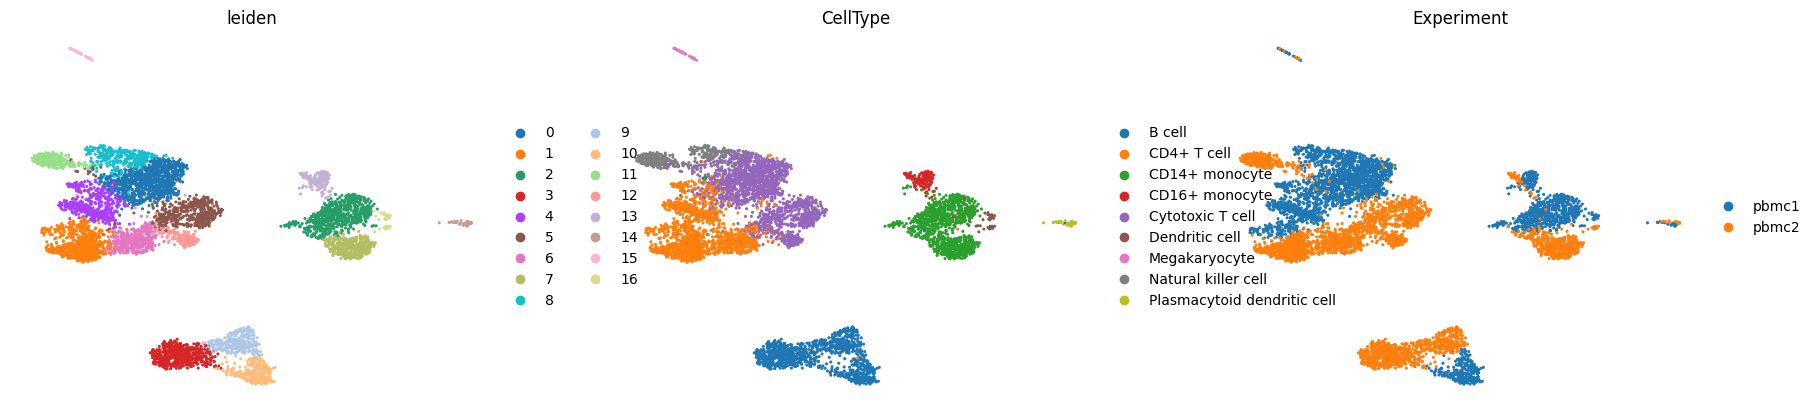

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)

# As in the paper
# Remove MALAT1
adata = adata[:, adata.var_names != 'MALAT1']
adata.var['mt'] = adata.var_names.str.startswith('MTRN')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 8, :]

adata.layers['counts'] = adata.X.toarray() # Keep the counts, for scDEF
adata.raw = adata

# Keep only HVGs
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=4000, layer='counts',
                           batch_key='Experiment') # Not required, but makes scDEF faster
adata = adata[:, adata.var.highly_variable]

# Process and visualize the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CellType', 'Experiment'], frameon=False)

## Learn scDEF

We tell scDEF to learn per-batch gene scales by setting `batch_key`. Combined with the sparsity and non-negativity constraints in the model, this provides enough power to correct batch effects and find shared variation between the two experiments.

In [5]:
scd = scdef.scDEF(adata, counts_layer='counts', batch_key='Experiment',)
print(scd) # inspect the scDEF object, which contains a copy of the input AnnData

scDEF object with 5 layers
	Layer names: factor, hfactor, hhfactor, hhhfactor, hhhhfactor
	Layer sizes: 100, 60, 30, 10, 1
	Layer shape parameters: 0.3, 0.3, 0.3, 0.3, 1.0
	Layer rate parameters: 0.3, 3.0, 6.0, 10.0, 30.0
	Layer factor shape parameters: 1.0, 1.0, 1.0, 1.0, 1.0
	Layer factor rate parameters: 100.0, 1.0, 1.0, 1.0, 1.0
	Using BRD with prior parameter: 1000.0
	Number of batches: 2
Contains AnnData object with n_obs × n_vars = 6124 × 4000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors',

Fit the model to data. By default, this will run two rounds of optimization with decreasing learning rates.

In [6]:
scd.learn() # learn the hierarchical gene signatures

100%|██████████| 1000/1000 [07:45<00:00,  2.15it/s, Loss=4.61e+6]


Check that the ELBO converged.

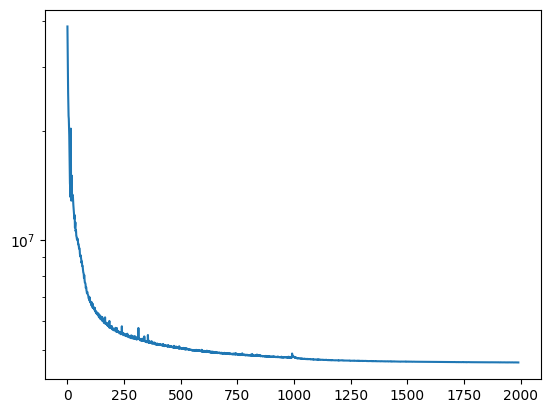

In [7]:
plt.plot(np.concatenate(scd.elbos)[10:])
plt.yscale('log')
plt.show()

scDEF updated the internal AnnData object with:
* Assignment of cells to factors at each layer: `scd.adata.obs`
* Weight of each cell to each factor at each layer: `scd.adata.obs`
* Cells by factors matrices at each layer: `scd.adata.obsm`
* Gene signatures for each factor at each layer: `scd.adata.uns`

Additionally, it created a graph in Graphviz format containing the learned hierarchy: `scd.graph`.

## Inspect size factors
scDEF is able to learn gene signatures that are not confounded by library sizes and gene detection rates because it explicitely models cell and gene scale factors. To make sure these are not captured in the factors, it's a good idea to confirm that the model successfully captured these biases.

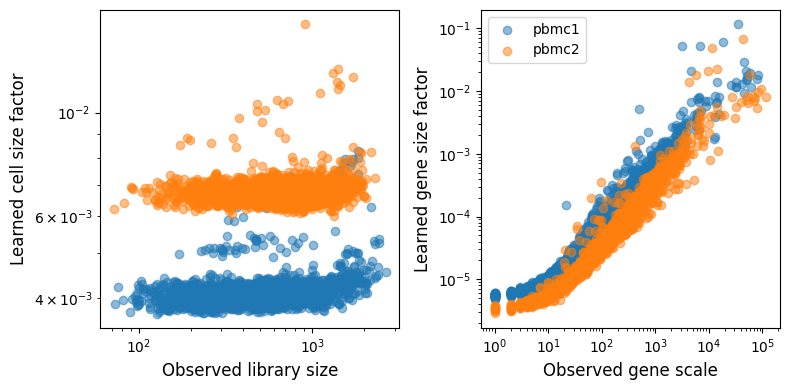

In [8]:
scd.plot_scales(alpha=0.5, show=True)
# plt.savefig('pbmcs2b_scales.pdf')

## Inspect automatic model pruning
By default, scDEF learns 100 factors at the highest resolution level (i.e., the lowest layer, layer 0). It also learns relevance estimates for each one, which leads to automatic model pruning. By default, after inference scDEF additionally only keeps the factors to which at least 10 cells attach and that have a relevance higher than 5 times the IQR of all the BRDs. This can be changed with `scd.filter_factors`. 

The `scd.plot_brd` utility function shows the relevancies learned for the factors.

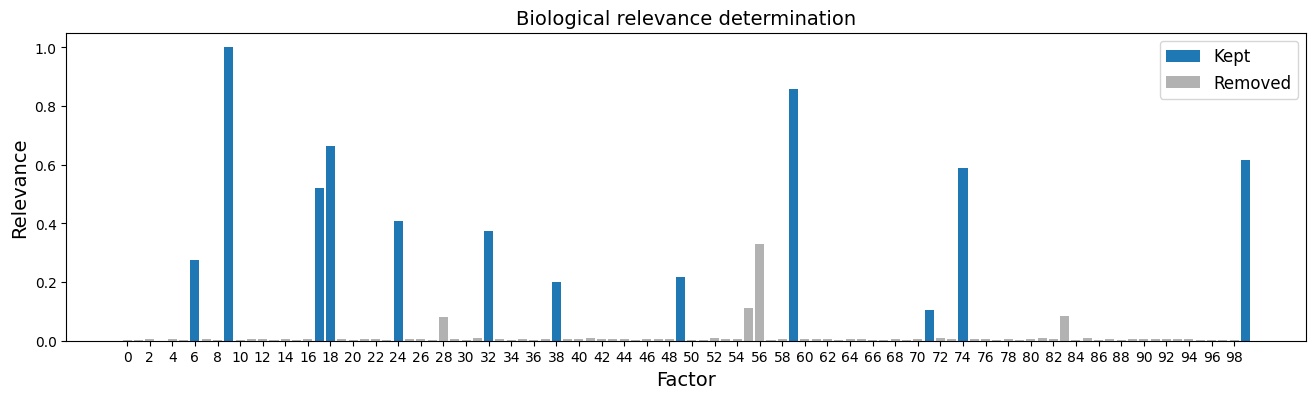

In [9]:
scd.plot_brd(figsize=(16,4), show=True)
# plt.savefig('pbmcs2b_brd.pdf')

The scDEF model is constructed in such a way that the kept factors are the sparser ones. The underlying assumption is that sparse factors (where only a few genes are active) reflect biological signal, and dense factors (where many genes are active) capture technical variation. We can assess the sparsity of all the factors through their Gini index.

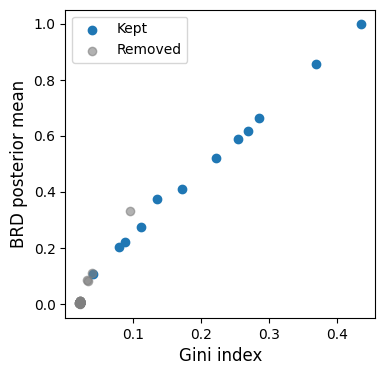

In [10]:
# scd.filter_factors()
scd.plot_gini_brd(show=True)
# plt.savefig('pbmcs2b_ginibrd.pdf')

## Downstream analyses

### Visualize scDEF graph
We can visualize the learned scDEF using `scd.make_graph`, which uses Graphviz to plot the scDEF graph.

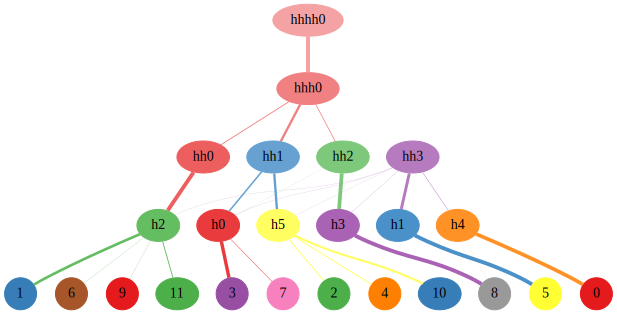

In [11]:
scd.make_graph(filled='factor', show_signatures=False) # simple graph with colorful nodes
scd.graph # Graphviz object

The scDEF hierarchy contains redudant connections, i.e., factors which capture the same cell population across different layers. We can merge these to obtain a more compact representation of the hierarchy.

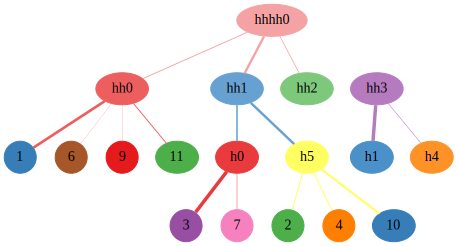

In [12]:
hierarchy_scdef = scd.get_hierarchy()
scd.make_graph(hierarchy=hierarchy_scdef, show_signatures=False, filled='factor')
scd.graph

We can also color each node by the proportion of attached cells from each batch. This helps us visualize the batch integration qualitatively.

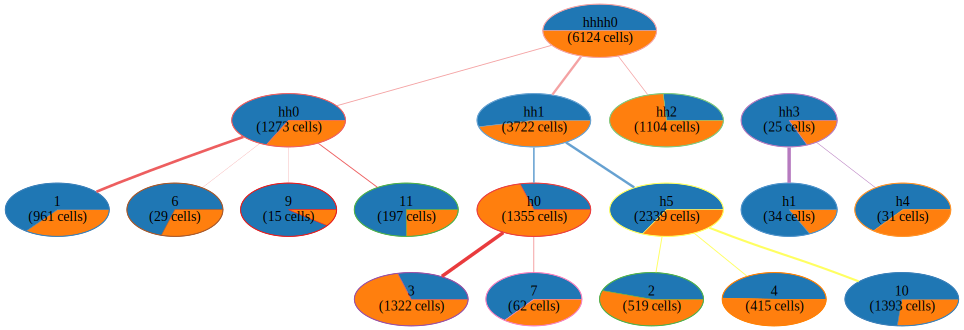

In [13]:
scd.make_graph(hierarchy=hierarchy_scdef, show_signatures=False, wedged='Experiment', 
               n_cells_label=True) # show number of cells in each node
scd.graph

Or we can remove the labels and scale the node sizes by the number of cells attached to the corresponding factors.

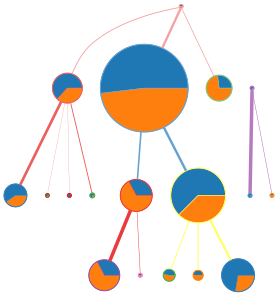

In [14]:
scd.make_graph(hierarchy=hierarchy_scdef, show_signatures=False, wedged='Experiment', 
               n_cells=True, show_label=False) # scale by number of cells and remove labels
scd.graph
# scd.graph.render('pbmcs2b_hrcscalenodes_experiment.pdf')

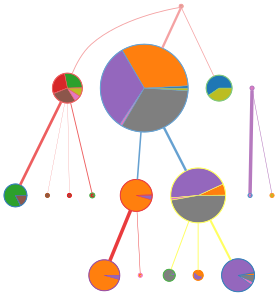

In [15]:
scd.make_graph(hierarchy=hierarchy_scdef, show_signatures=False, wedged='CellType', 
               n_cells=True, show_label=False) # scale by number of cells and remove labels
scd.graph
# scd.graph.render('pbmcs2b_hrcscalenodes_celltype.pdf')

And we can directly visualize the gene expression signatures associated with each factor in the hierarchy.

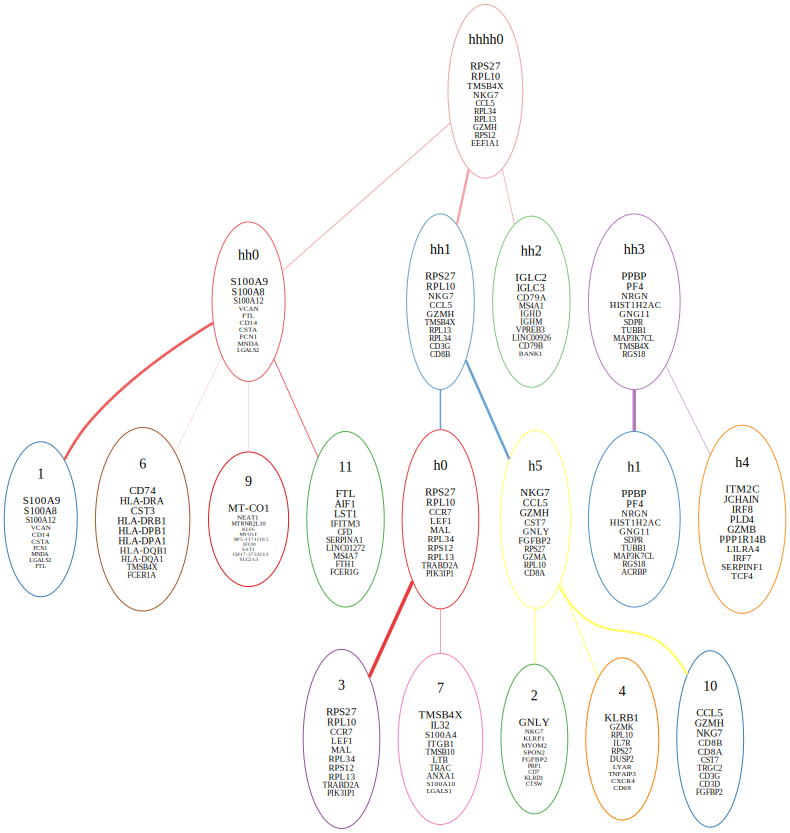

In [16]:
scd.make_graph(hierarchy=scd.get_hierarchy())
scd.graph

### Visualize cell to factor weights
Each cell assigns a weight to a factor. The factors at the lowest level tend to capture different cell populations at high resolution which are aggregated in the upper levels. We can easily visualize the weights (or scores) of the factors at the lowest level in the original UMAP.

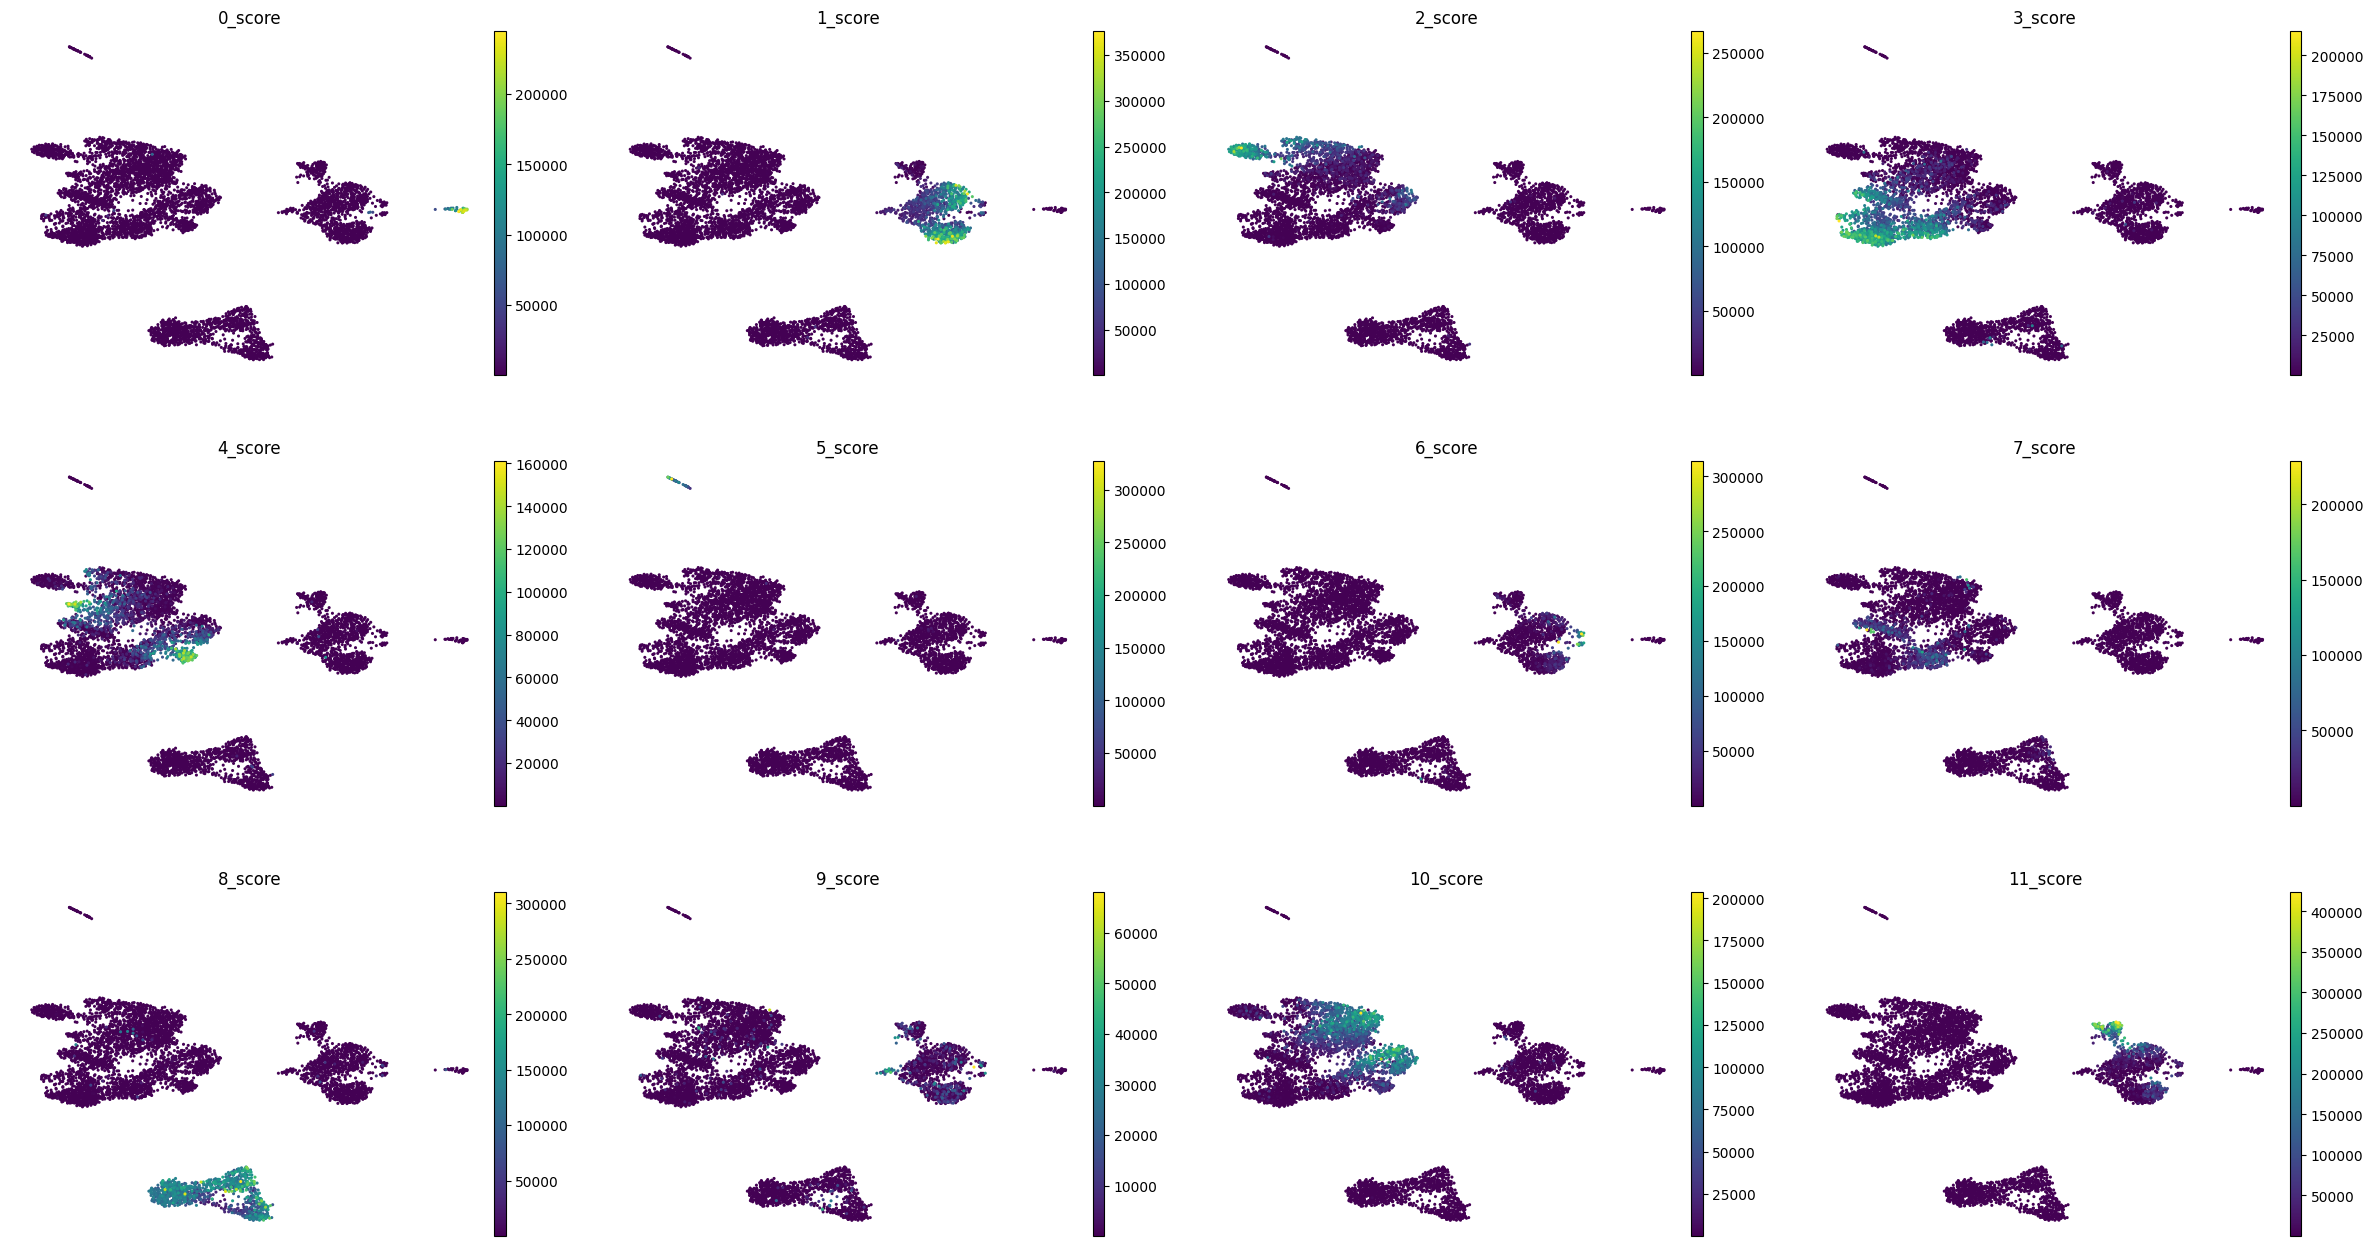

In [17]:
sc.pl.umap(scd.adata, color=[f'{i}_score' for i in range(len(scd.factor_lists[0]))], frameon=False)

### Visualize cell to factor assignments
scDEF assigns each cell to each factor at each level of resolution. We can visualize these assignments in the original UMAP.

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


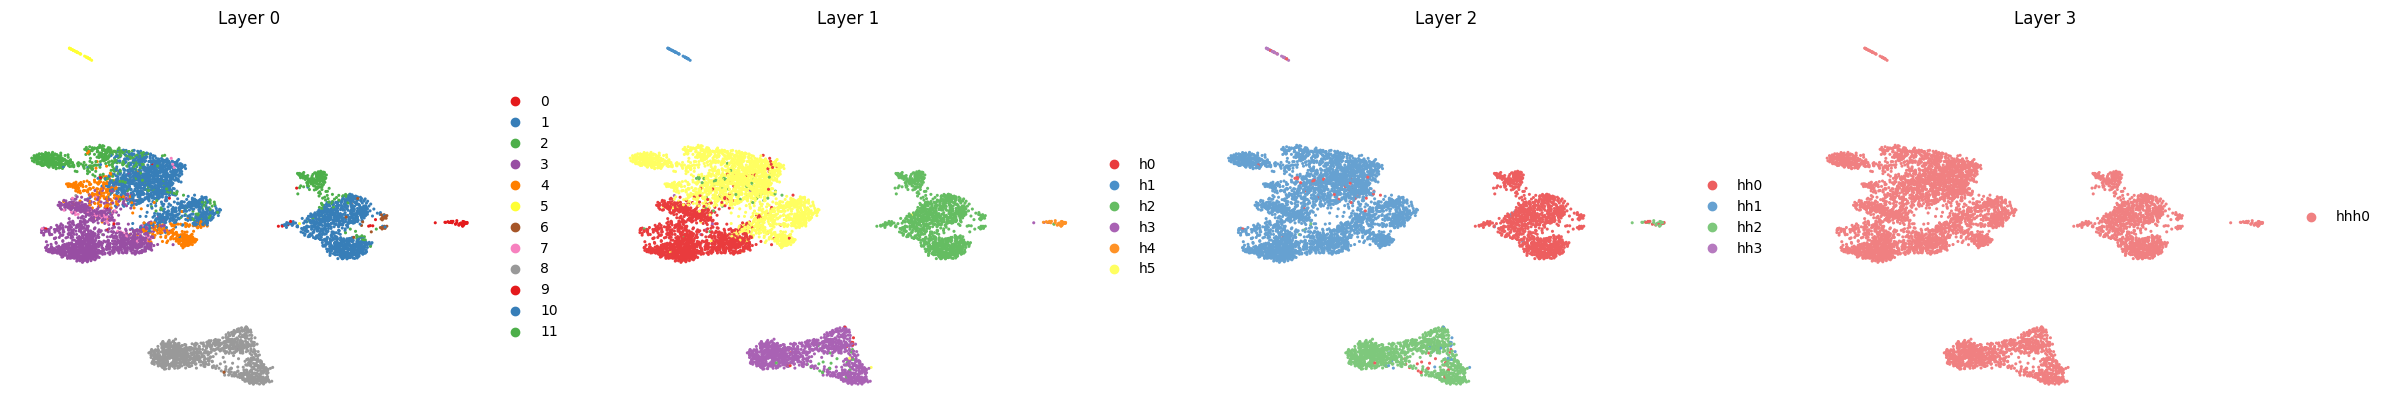

In [18]:
scd.filter_factors(filter_up=True)
sc.pl.umap(scd.adata, color=['factor', 'hfactor', 'hhfactor', 'hhhfactor'], 
       title=['Layer 0', 'Layer 1', 'Layer 2', 'Layer 3'], frameon=False)

### UMAP visualization of scDEF layers
We can use the factors at each layer of the learned scDEF as embeddings of the cells in lower-dimensional spaces, and visualize them in 2D using, for example, a UMAP. We will color them using both the provided cell type annotations and the batch of origin.

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/pytho

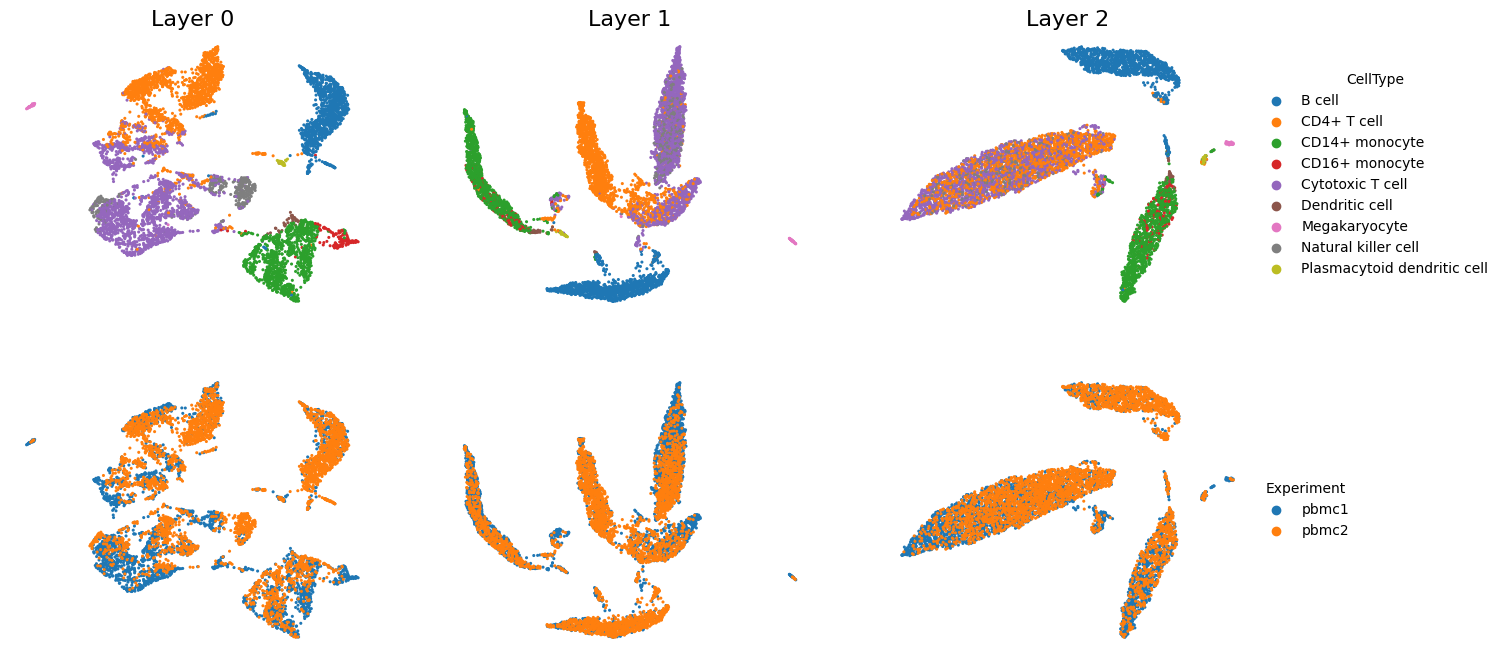

In [19]:
scd.plot_umaps(color=['CellType', 'Experiment'], figsize=(16,8), fontsize=16, show=True)
# plt.savefig('pbmcs2b_umaps.pdf', bbox_inches='tight')

### Association of factors with annotations
By attaching cells to the factors that they assign most of their weight to, and comparing those assignments with the ground truth annotations, we can check which factors associate most strongly with which annotations.

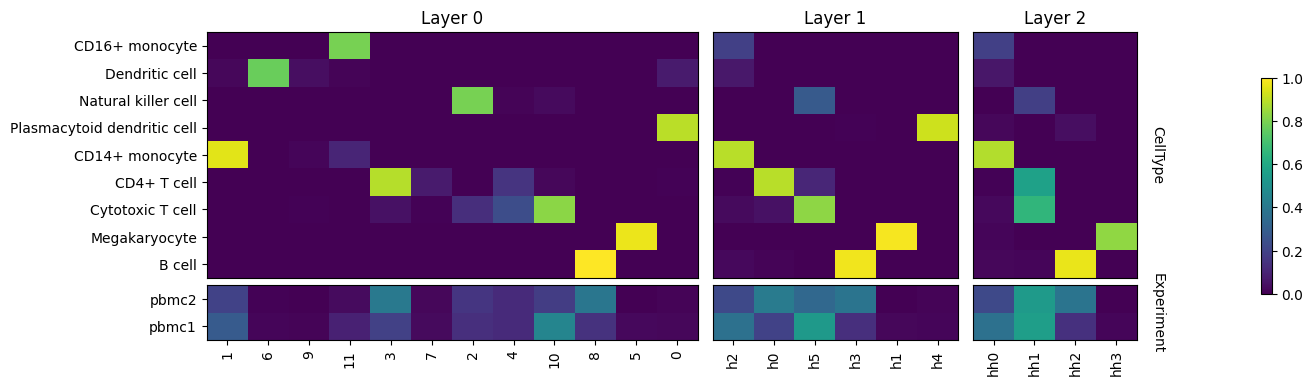

In [20]:
obs_keys = ['CellType', 'Experiment']
scd.plot_obs_scores(obs_keys, figsize=(16,4), show=True)
# plt.savefig('pbmcs2b_obskeys.pdf', bbox_inches='tight')

If we take a step further and label the factors by the annotations that they most strongly associate with, we can further validate the hierarchy.

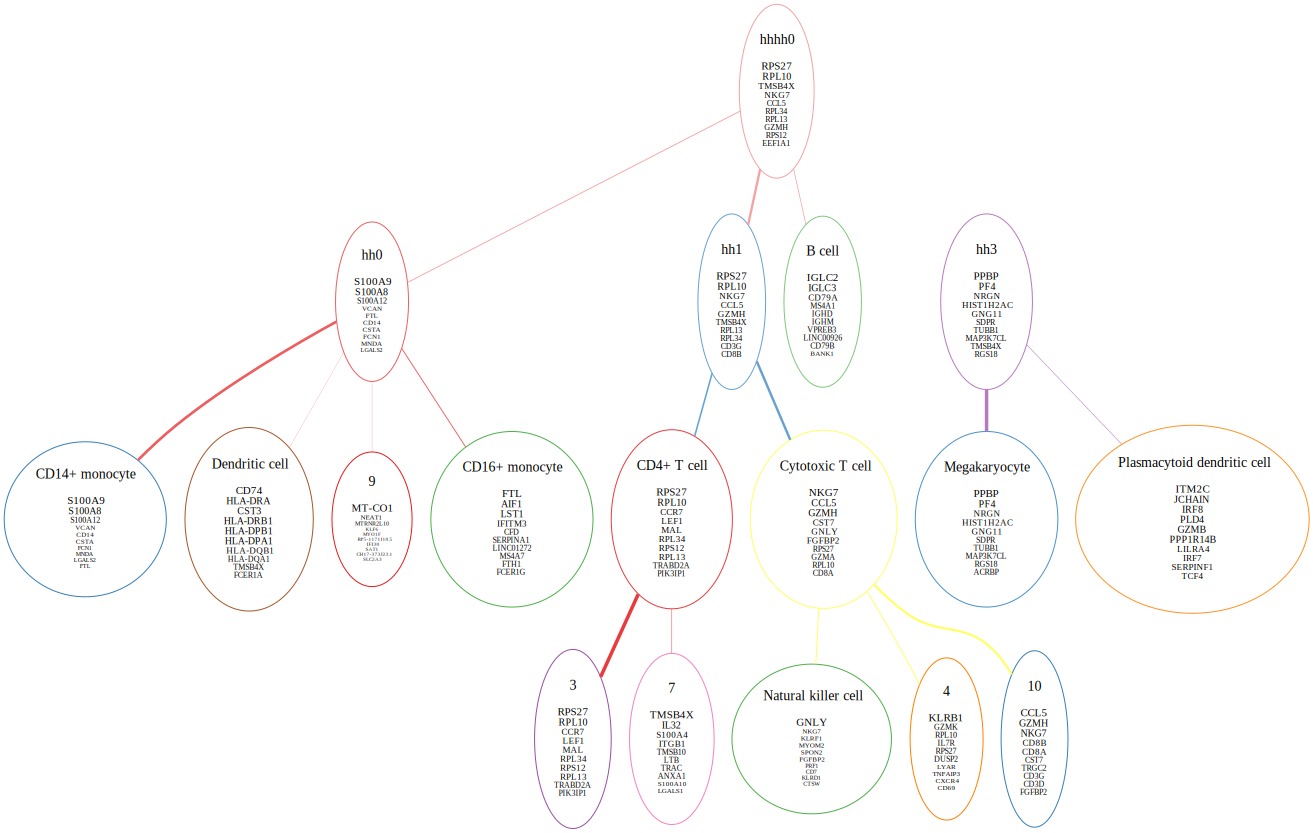

In [21]:
# Assign factors in simplified hierarchy to annotations
assignments, matches = scd.assign_obs_to_factors(['CellType'], 
                        factor_names=scdef.utils.hierarchy_utils.get_nodes_from_hierarchy(hierarchy_scdef))

scd.make_graph(hierarchy=hierarchy_scdef, factor_annotations=matches)
scd.graph